## PCA Task

Perform PCA-based anomaly detection.
- Set threshold that results in few false positives 
- Plot the residuals in one signal 

 

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
%matplotlib inline

train_data1 = pd.read_csv('./BATADAL_dataset03.csv', sep = ',')
train_data2 = pd.read_csv('./BATADAL_dataset04.csv', sep = ', ')

print("Shape non-attack: ", train_data1.shape)
print("Shape train: ", train_data2.shape)

# All numeric values except from the first (datetime)
# print(train_data1.columns.values)

# convert DATETIME to timestamp
train_data = pd.concat([train_data1, train_data2], axis=0, ignore_index=True)
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], infer_datetime_format=True)
train_data['Year'] = train_data['DATETIME'].apply(lambda x: x.year)
train_data['Month'] = train_data['DATETIME'].apply(lambda x: x.month)
train_data['Day'] = train_data['DATETIME'].apply(lambda x: x.day)
train_data['Hour'] = train_data['DATETIME'].apply(lambda x: x.hour)

# Final versions of training and test dataframes
y = train_data['ATT_FLAG'].values
train_data = train_data.drop(columns=['DATETIME', 'ATT_FLAG'])


# Training and test dataset
X = train_data.values

# drop columns with 0 variance as they can be of no use
index = np.std(X, axis=0) != 0
X = X[:, index]

# separate the two training datasets again
data= X[:8761]
data_test = X[8761:]
labels1 = y[:8761]
labels2 = y[8761:]

# NaNs
print("Number of NaN values in training dataset: ", np.sum(pd.isna(train_data).values))
print("Training normal dataset shape: ", data.shape)
print("Training attack dataset shape: ", data_test.shape)
print("Number of attacks: ", np.sum(y==1))
print(labels2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


Shape non-attack:  (8761, 45)
Shape train:  (4177, 45)
Number of NaN values in training dataset:  0
Training normal dataset shape:  (8761, 40)
Training attack dataset shape:  (4177, 40)
Number of attacks:  219
[-999 -999 -999 ... -999 -999 -999]


In [5]:
#Normalize the data to apply PCA
normalize = StandardScaler()
norm_data =  normalize.fit_transform(data)
print(np.std(norm_data, axis=0))

att_data= normalize.fit_transform(data_test)
print(np.std(att_data,axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]


### Determine optimal components

In [50]:
def determine_num_components(X, threshold):
    pca = PCA()
    pca.fit(X)
    
    i = 0
    for comp in pca.components_:
        proj = np.matmul(norm_data, comp)
        std = np.std(proj)
        if np.max(np.abs(proj)) > threshold*std:
            break
        i = i+1
    P_normal = pca.components_[:i, :].T
    P_anomal = pca.components_[i:, :].T
    return i, P_normal, P_anomal

n, P_n, P_an = determine_num_components(norm_data, 3)
print(n)
print(P_n.shape)
print(P_an.shape)

2
(40, 2)
(40, 38)


### Compute projections

In [44]:
y_hat = np.zeros_like(norm_data)
y_bar = np.zeros_like(norm_data)
for i in range(len(norm_data)):
    y_hat[i, :] = np.matmul(np.matmul(P_n, P_n.T), norm_data[i,:])
    y_bar[i, :] = np.matmul(np.matmul(P_an, P_an.T), norm_data[i,:])

(8761, 40)
100% of variance is captured


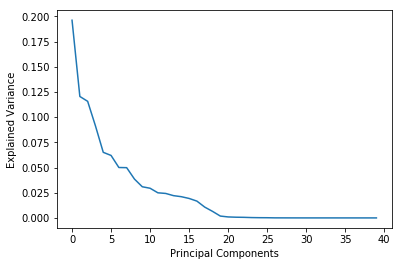

In [4]:
pca = PCA(n_components= norm_data.shape[1])
norm_pca = pca.fit_transform(norm_data)
print(norm_pca.shape)
print('{:0.0%} of variance is captured'.format(sum(pca.explained_variance_ratio_)))


plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.plot(pca.explained_variance_ratio_)

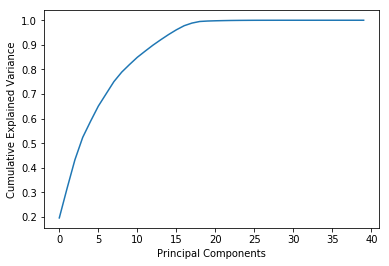

In [5]:
# plot cumulative variance captured of principle components

plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_ratio_.cumsum())

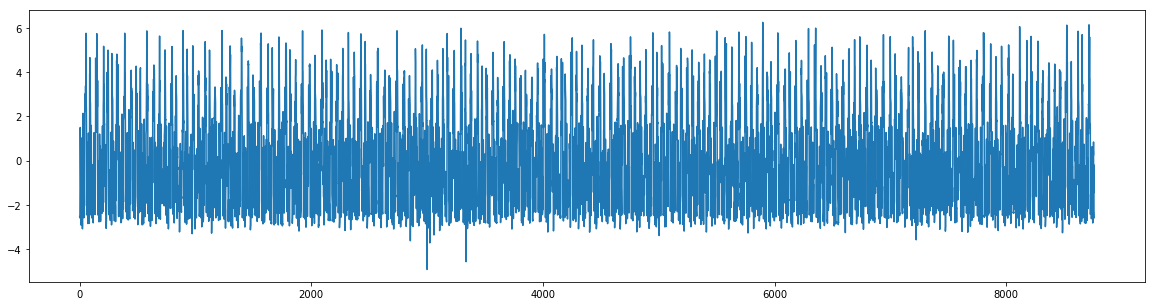

In [6]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(norm_pca[:,1])

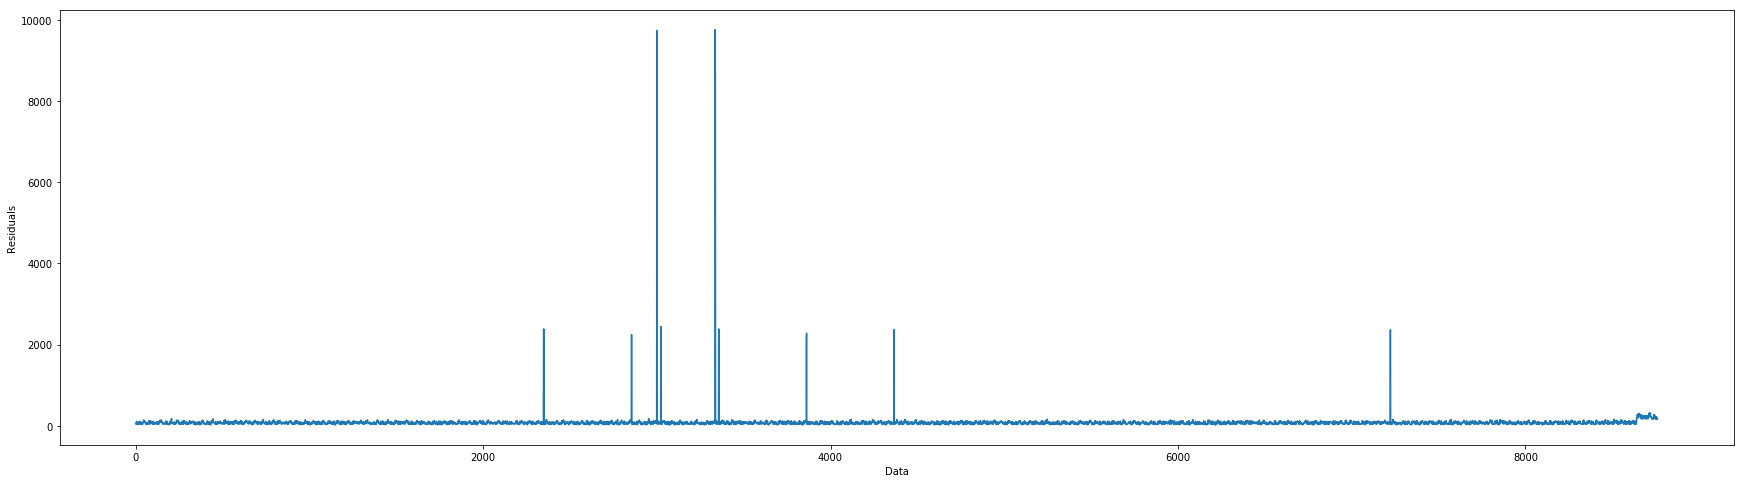

<Figure size 2160x576 with 0 Axes>

In [7]:
residuals = norm_data - pca.inverse_transform(norm_data)
residuals = np.square(residuals)
residuals = residuals.sum(axis=1 )


# Plot residuals on training set to check for abnormalities 
figure, ax = plt.subplots(figsize=[30,8])
plt.xlabel('Data')
plt.ylabel('Residuals')
plt.figure(figsize=[30,8])
ax.plot(residuals)



(8761, 19)
99% of variance is captured


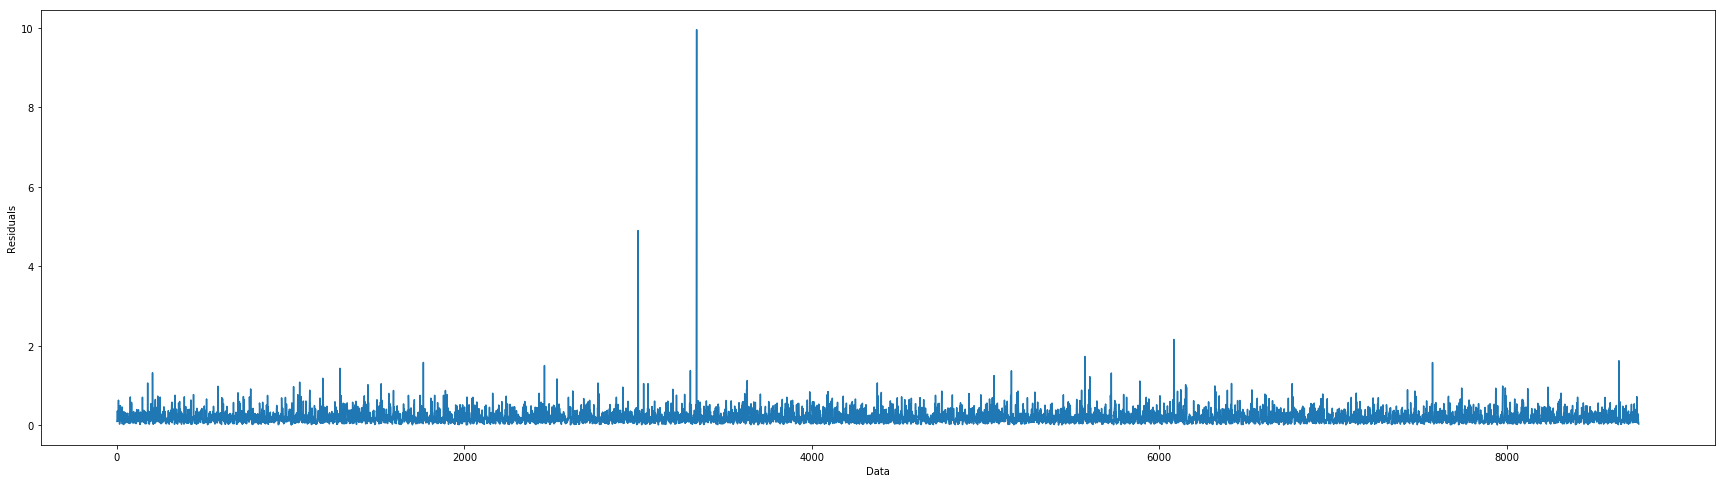

<Figure size 2160x576 with 0 Axes>

In [11]:
num= 19 # number of components 

pca_opt = PCA(n_components=num)
pca_data = pca_opt.fit_transform(norm_data)
print(pca_data.shape)
norm_inv = pca_opt.inverse_transform(pca_data)
print('{:0.0%} of variance is captured'.format(sum(pca_opt.explained_variance_ratio_)))

#Compute residuals
residual = norm_data - norm_inv
residual = np.sum(np.square(residual),axis =1)
 

#plot the new residuals
figure, ax = plt.subplots(figsize=[30,8])
plt.xlabel('Data')
plt.ylabel('Residuals')
plt.figure(figsize=[30,8])
ax.plot(residual)




The figure above shows that there are abnormalities in the train data. We need to remove them.

We computed the threshold according to the paper "Diagnosing Network-Wide Traffic Anomalies" by et al Anuk. The threshold is computed using the Q-Statistic function. 


In [6]:
#### Q-statistic function 
variance = pca.explained_variance_
sort= np.sort(variance )
rev_sort = sort[-1::-1]

l1 = rev_sort
l2 = np.power(rev_sort, 2)
l3 = np.power(rev_sort,3)

F1 = sum(l1[num:])
F2 = sum(l2[num:])
F3 = sum(l3[num:])
#a = 
Ca = 0.999 # number they used in the paper
h0 = 1 - 2.0* F1*F3/ (3.0*(F2**2))
threshold = F1*((Ca*np.sqrt(2*F2*(h0**2))/F1)+ 1 + (F2*h0*(h0-1)/F1**2))**(1/h0)
print(threshold)


NameError: name 'pca' is not defined

(0, 5)

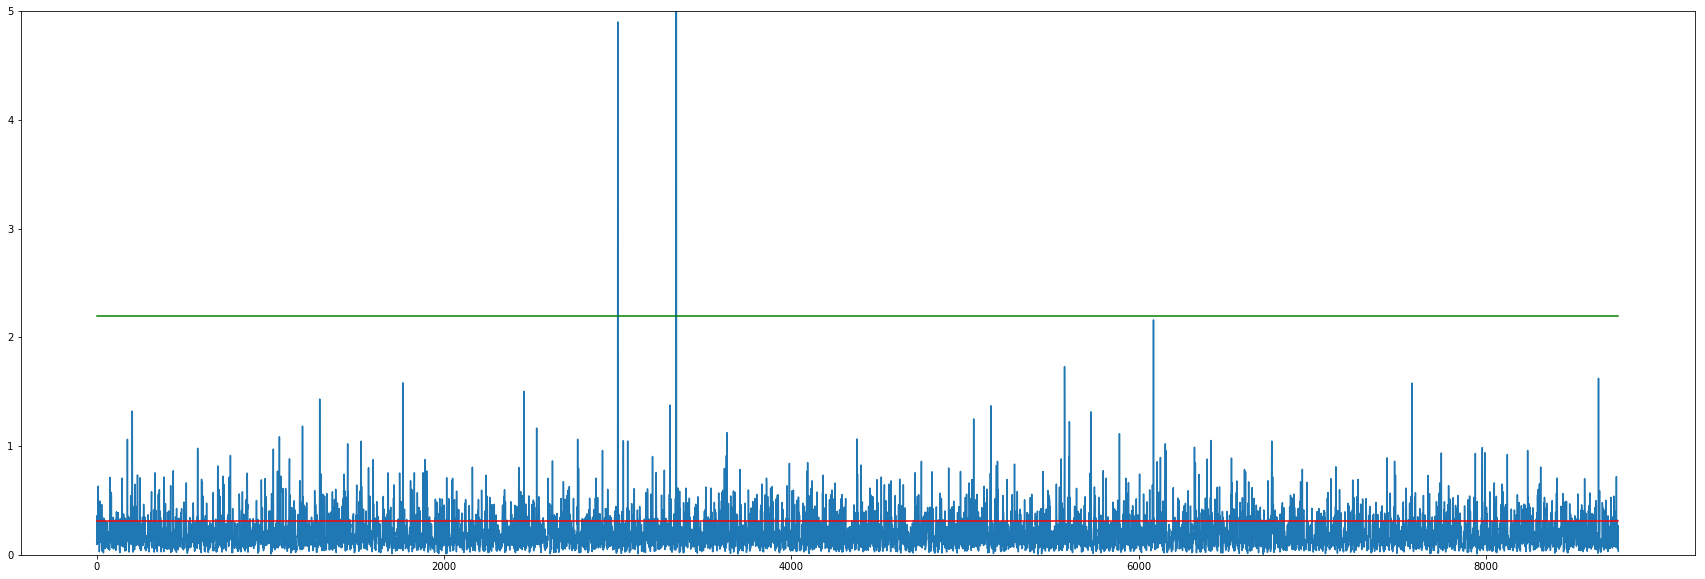

<Figure size 2160x720 with 0 Axes>

In [13]:
threshold_2 = 2.2 #  Manual tune the threshold


figure, ax = plt.subplots(figsize=[30,10])
plt.figure(figsize=[30,10])
ax.plot(residual)
ax.plot([0,len(residual)],[threshold,threshold],'r')
ax.plot([0,len(residual)],[threshold_2,threshold_2],'g')
ax.set_ylim([0, 5])


In [14]:
#Apply the same model to the test set

pca_1 = PCA(n_components= num)
pca_att = pca_1.fit_transform(att_data)
print(pca_data.shape)
att_inv = pca_1.inverse_transform(pca_att)
print('{:0.0%} of variance is captured'.format(sum(pca_opt.explained_variance_ratio_)))


residuals_att0 = att_data - att_inv
residuals_att = np.sum(np.square(residuals_att0),axis=1)



(8761, 19)
99% of variance is captured


### Results for different thresholds

Below are the results for the different thresholds 

In [18]:
# threshold obtained from Q-statistic 
labels = np.array(labels2)
predicted_labels = []
for i in range(len(residuals_att)):
    if residuals_att[i] >= threshold:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(predicted_labels)):
    if(predicted_labels[i] == 1 and labels[i] == 1):
        tp = tp + 1
    if(predicted_labels[i] == 1 and labels[i] == -999):
        fp = fp + 1
    if(predicted_labels[i] == 0 and labels[i] == 1):
        fn = fn + 1    
    if(predicted_labels[i] == 0 and labels[i] == -999):
        tn = tn + 1


Accuracy=((tp+tn)/(tp+tn+fp+fn)) * 100.0
Precision=(tp / (tp + fp)) * 100.0
Recall = (tp / (tp + fn)) * 100.0
F_score = 100.0*2*tp /(2*tp + fp + fn)
print ("True Positives:", tp)
print ("False Positives:", fp)
print("Accuracy: %.2f" % Accuracy)
print("Precision: %.2f" % Precision)
print("Recall: %.2f" %Recall)
print("F-score: %.2f" % F_score)


True Positives: 113
False Positives: 1428
Accuracy: 63.28
Precision: 7.33
Recall: 51.60
F-score: 12.84


In [237]:
# threshold obtained from Q-statistic 
labels = np.array(labels2)
predicted_labels = []
for i in range(len(residuals_att)):
    if residuals_att[i] >= threshold_2:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(predicted_labels)):
    if(predicted_labels[i] == 1 and labels[i] == 1):
        tp = tp + 1
    if(predicted_labels[i] == 1 and labels[i] == -999):
        fp = fp + 1
    if(predicted_labels[i] == 0 and labels[i] == 1):
        fn = fn + 1    
    if(predicted_labels[i] == 0 and labels[i] == -999):
        tn = tn + 1


Accuracy=((tp+tn)/(tp+tn+fp+fn)) * 100.0
Precision=(tp / (tp + fp)) * 100.0
Recall = (tp / (tp + fn)) * 100.0
F_score = 100.0*2*tp /(2*tp + fp + fn)
print ("True Positives:", tp)
print ("False Positives:", fp)
print("Accuracy: %.2f" % Accuracy)
print("Precision: %.2f" % Precision)
print("Recall: %.2f" %Recall)
print("F_score: %.2f" % F_score)

True Positives: 11
False Positives: 78
Accuracy: 93.15
Precision: 12.36
Recall: 5.02
F_score: 7.14
